<a href="https://colab.research.google.com/github/lingzhou0/math412-fall2025/blob/main/Topic6-time-series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUMA 2025 - Algebraic and Computational Topology

## Problem session 3: Persistent Homology


Author: Jose A. Perea

Date: 04/13/2025

In [ ]:
!pip install ripser

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.5 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=384c1369af0a542465ab1a190f96fd03f9fd2b8a665d8cf0c13d4ae75ebabb52
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [ ]:
# topological data analysis
from ripser import ripser
from persim import plot_diagrams

# plotting and visualization
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

# Numerical
from scipy.spatial import distance
from scipy.interpolate import CubicSpline
from scipy.stats import kendalltau
import numpy as np


In [ ]:
def plot_barcodes(diagrams, alpha_max, width = 1.5):
    max_dim = len(diagrams)
    fig, axs = plt.subplots(max_dim)
    fig.suptitle('Barcodes')
    for dim in range(max_dim):
        barcode = np.copy(diagrams[dim])
        ind_inf = np.isinf(barcode.T[1])
        barcode[ind_inf, 1] = alpha_max
        h = 1
        for i in range(len(barcode)):
            x = barcode[i]
            y = [h,h]
            axs[dim].plot(x, y, linestyle= '-', c='#1f77b4', linewidth = width)
            if ind_inf[i]:
                axs[dim].scatter([alpha_max],[h],  s=10, marker='>', c='#1f77b4')
            h += 1
        axs[dim].set_xlim(0, 1.05*alpha_max)
        axs[dim].set_ylim(0,h)
        axs[dim].get_yaxis().set_ticks([]);
        axs[dim].spines['right'].set_color('none')
        axs[dim].spines['top'].set_color('none')
        axs[dim].text(0.3,1,'$\mathrm{bcd}^{\mathcal{R}}_{'+str(dim)+'}(X)$', verticalalignment='bottom')

### Data sets

$X$ : Set of points

$\mathbf{d}_X : X\times X \rightarrow \mathbb{R}$ distance function


In [ ]:
np.random.seed(1223)

n_data = 30
theta = np.random.uniform(0, 2*np.pi, n_data)
data = np.array([np.cos(theta) , np.sin(theta) , np.zeros_like(theta)]).T
data += np.random.normal(0, 0.08, data.shape)

fig = go.Figure(data=[go.Scatter3d(
    x=data.T[0], y=data.T[1], z=data.T[2],
    mode ='markers',
    marker=dict(size = 3 , color = 'grey'))])

fig.update_layout(scene= dict(zaxis = dict(range=[-1, 1])))
fig.show()



---



# Part I : Persistent Homology

### Rips Filtration

Given a dataset $(X,\mathbf{d}_X)$, its Rips filtration is defined as:

$$\mathcal{R}(X) = \Big\{\,  R_\alpha(X,\mathbf{d}_X) \Big\}_{ \alpha \geq 0} $$
where
$$R_\alpha(X, \mathbf{d}_X) = \Big\{\, \{x_0 , \ldots, x_k\} \subseteq X  \;\; : \;\;  \max_{0 \leq i \leq j \leq k} \mathbf{d}_X(x_i, x_j) \leq \alpha\, \Big\} $$

**Do:** Use the cell below to visualize the Rips complex of $X$ at various distance thresholds $\alpha \geq 0 $.

**Question:**

1.   $b_0(R_\alpha(X, \mathbf{d}_X)) = 5$   when  $\alpha =  $

2.   $b_1(R_\alpha(X, \mathbf{d}_X)) = 1$   when  $\alpha = $

3.   $b_0(R_\alpha(X, \mathbf{d}_X)) = 1$ and  $b_1(R_\alpha(X, \mathbf{d}_X)) = 0 $
 when $\alpha = $

In [ ]:
alpha = 0.5 # Change this value!!

distMat = distance.squareform(distance.pdist(data))

ii = []; jj = []; kk = []
e_x =[]; e_y =[]; e_z =[]

for i in range(n_data):
    for j in range(i+1,n_data):
        if distMat[i,j] < alpha:
            # add edge (i,j)
            e_x.extend([data[i,0], data[j,0], None])
            e_y.extend([data[i,1], data[j,1], None])
            e_z.extend([data[i,2], data[j,2], None])

            for k in range(j+1,n_data):
                if np.max([distMat[j,k], distMat[i,k]]) < alpha:
                    # add triangle (i,j,k)
                    ii.append(i); jj.append(j); kk.append(k)

vertices = go.Scatter3d(mode = 'markers', name = 'vertices',
                        x = data.T[0], y = data.T[1],  z = data.T[2],
                        marker=dict(size = 3 , color = 'grey'))

edges = go.Scatter3d(mode='lines', name = 'edges',
                     x=e_x, y=e_y, z=e_z,
                     line=dict(color= 'rgb(70,70,70)', width=1))

triangles = go.Mesh3d(x=data.T[0], y=data.T[1], z=data.T[2],  i = ii, j = jj, k = kk,  color='lightpink', opacity=0.2)

fig = go.Figure(data=[vertices, edges, triangles])
fig.update_traces(hoverinfo="none")
fig.update_layout(scene= dict(
                      xaxis = dict(showspikes=False),
                      yaxis = dict(showspikes=False),
                      zaxis = dict(showspikes=False,range=[-1, 1])))
fig.show()

### Computing Persistence via Ripser

U. Bauer: "Ripser is a lean C++ code for the computation of Vietoris–Rips persistence barcodes. It can do just this one thing, but does it extremely well."

Original C++ library : https://github.com/Ripser/ripser

Accompanying paper : https://arxiv.org/pdf/1908.02518.pdf

Python library: https://ripser.scikit-tda.org/en/latest


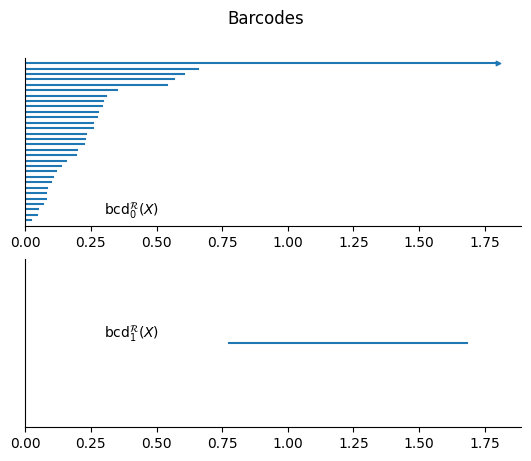

In [ ]:
# Persistence Computation
rips_persistence = ripser(data, maxdim=1)

dgms = rips_persistence['dgms']
plot_barcodes(dgms,1.8);

### Persistence diagrams

$$ \mathrm{dgm}_j^\mathcal{R}(X) = \Big\{ (a,b) \in \mathbb{R}^2 \;\; : \;\; [a,b) \in \mathrm{bcd}_j^\mathcal{R}(X)  \Big\}$$

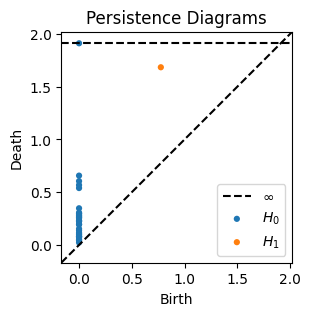

In [ ]:
plt.figure(figsize = (3,3))
plot_diagrams(dgms, title='Persistence Diagrams')

### Data Example: A Noisy Torus

In [ ]:
np.random.seed(2)
n_data = 25000
R = 5
r = 2
data = np.zeros((3, n_data))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi

data[0] = (R + r*np.cos(s))*np.cos(t)
data[1] = (R + r*np.cos(s))*np.sin(t)
data[2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)
data = data.T

# Plot the data
fig = go.Figure(data=[go.Scatter3d(
    x=data.T[0], y=data.T[1], z=data.T[2],
    mode ='markers',
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( width=900, height=450)
fig.show()

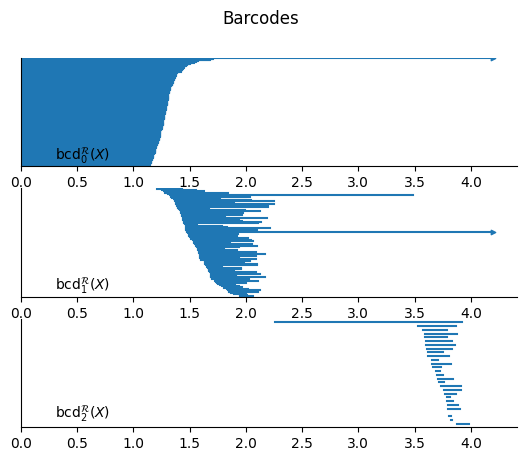

In [ ]:
## Persistence Computation

# Parameters
max_alpha = 4.2
max_homology_dim = 2

# Run Ripser
rips_persistence = ripser(data,  maxdim=max_homology_dim , thresh = max_alpha , n_perm =200)

# Visualize barcodes
dgms = rips_persistence['dgms']
plot_barcodes(dgms,max_alpha);

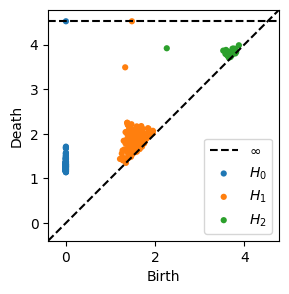

In [ ]:
# Plot persistence diagrams
plt.figure(figsize = (3,3))
plot_diagrams(dgms)

**Questions**

1.  Let $T$ be the torus and $X$  the data above. Find $\alpha$ so that $b_j(R_\alpha(X)) = b_j(T)$ for $0 \leq j \leq 2$.

2. What visualization did you find more useful, the barcodes or the diagrams?

**Your answers:**

1.

2.



---



# Part II: Sliding windows and persistence

Given a time series $f: I \subseteq \mathbb{R} \rightarrow  \mathbb{R}$ a delay $\tau > 0$ and  a dimenison $d+1 \in \mathbb{N}$, the **sliding window embedding** of $f$ at $t \in I$ is

$$SW_{d,\tau}f(t) = \begin{bmatrix}f(t) \\ f(t + \tau)  \\ \vdots \\ f(t + d\tau)  \end{bmatrix}  \in \mathbb{R}^{d+1}$$

and the **sliding window point cloud** is

$$\mathbb{SW}_{d,\tau} f = \{SW_{d,\tau}(t) \;\; : \;\; t\in I\} \subseteq \mathbb{R}^{d+1}$$

In [ ]:
def SW_cloud(f, tau, d, n_data):
    # Inputs:
    # f : time series -- array of size (2,N) (x and y values) or (1,N) (only y values)
    # tau: delay -- positive real number
    # d : gives embedding dimension d+1 -- integer
    # n_data : desired number of points in SW point cloud -- intenger
    #
    # Output:
    # SW : sliding window point cloud -- array of size (n_data,  d+1)

    #Step 1: turn f into a cubic spline
    if len(f.shape)==1:
        N = len(f)
        x_vals = np.linspace(0,1,N)
        y_vals = f
    else:
        x_vals = f[0]
        y_vals = f[1]

    f = CubicSpline(x_vals , y_vals)

    #Step 2: create the t values where to evaluate SW_f
    t_vals = np.linspace(np.min(x_vals) , np.max(x_vals) - d*tau, n_data) # the starting t

    #Step 3: evaluate the sliding window point cloud
    SW = []
    for t in t_vals:
        SW_f_t = f(t + np.arange(0,d+1)*tau)
        SW.append(SW_f_t)

    return np.array(SW)

### Toy example

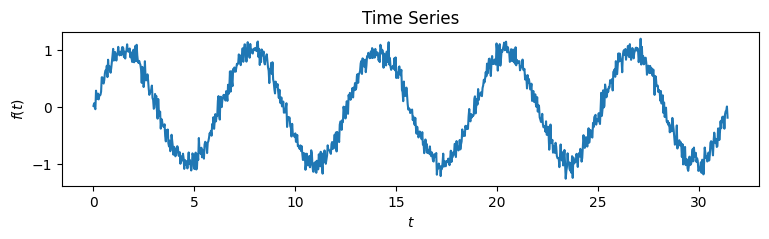

In [ ]:
# Time Series Example : Noisy sin(t)

period = 2*np.pi   ## <-- sin(t) is periodic with period 2pi
t_vals = np.linspace(0 , 5*period, 1000)
noise_level = 0.1

y_vals  = np.sin(t_vals) + noise_level*np.random.randn(*t_vals.shape)

plt.figure(figsize = (9,2))
plt.plot(t_vals, y_vals);
plt.title('Time Series');
plt.xlabel('$t$');
plt.ylabel('$f(t)$');


In [ ]:
## Compute the Sliding window point cloud

f = np.array([t_vals, y_vals]) ## <---- toy time series

# Parameters for SW
d = 2
tau = period/(d+1)  ## <--- the SW theory says this is the best choice
n_data = 5000

# Compute SW
SW_f = SW_cloud(f,tau, d, n_data )

# Plot the sliding window point cloud

fig = go.Figure(data=[go.Scatter3d(
    x=SW_f.T[0], y=SW_f.T[1], z=SW_f.T[2],
    mode ='markers',
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( width=900, height=450)
fig.show()

**Questions**
1. What happens to the sliding window point cloud if the noise level is increased? See what happens.

2. What happens to $\mathbb{SW}_{d,\tau} f$ if $\tau$ is changed (e.g., to 0.1 or 6.1). See what happens.

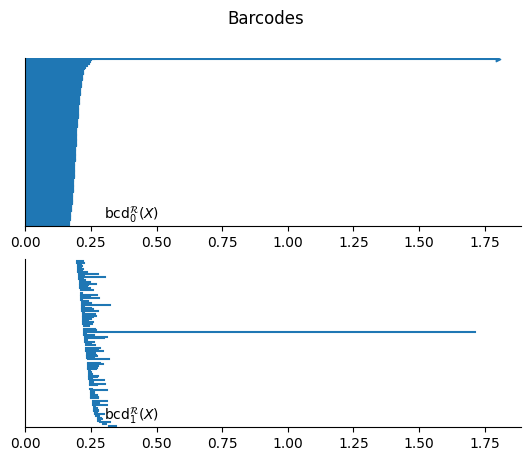

In [ ]:
# Persistent homology of SW_f

# Parameters
max_alpha = 1.8
max_homology_dim = 1

# Run Ripser
rips_persistence = ripser(SW_f,  maxdim=max_homology_dim , thresh = max_alpha , n_perm =200)

# Visualize barcodes
dgms = rips_persistence['dgms']
plot_barcodes(dgms,max_alpha);

In [ ]:
# Maximum 1-dimensional persistence
max_pers_dim_1 = np.max(dgms[1][:, 1] - dgms[1][:, 0])
print('The max persistence in bcd_1 is', max_pers_dim_1)

The max persistence in bcd_1 is 1.4883134365081787


**Questions:**

1. Focus on $\mathrm{bcd}_1^\mathcal{R}(\mathbb{SW}_{d,\tau}f)$. What happens to the length of the longest bar (i.e., to its <u>persistence</u>) if $\tau$ takes sub-optimal values (e.g., 6.0 or 0.1). See what happens.

2. What happens if the noise level is increased? See what happens.

**Your answers:**

1.

2.



---



# Part III: Sliding Windows and 1-Persistence Scoring (SW1PerS)

This activity puts everything together

In [ ]:
# Generate a list of synthetic periodic signals corrupted with varying levels of random noise
np.random.seed(2)
t_vals = np.linspace(0,2*np.pi, 1000)

noise = np.random.randn(*t_vals.shape)
noise = noise/np.max(np.abs(noise))

n_signals = 20  # number of signals to be generated

Y_vals = []

for i, noise_level in enumerate(np.linspace(0,1,n_signals)):
  y_vals = (1- noise_level)*np.sin(5*t_vals - np.pi*np.random.rand()) + noise_level*noise
  Y_vals.append(y_vals)

true_ranking = np.random.permutation(n_signals) +1

Y_vals = np.array([Y_vals[i-1] for i in true_ranking])


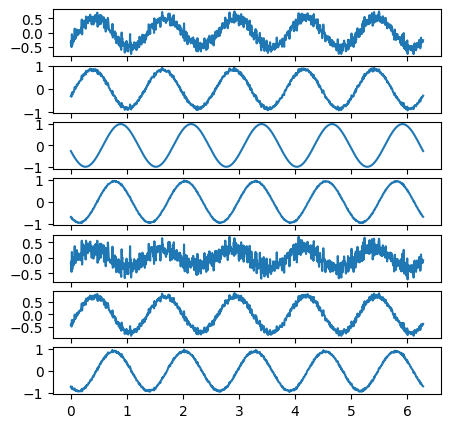

In [ ]:
# Plot the first few signals
n_plots = 7
plt.figure(figsize = (5, 5))

for i in range(n_plots):
  plt.subplot(n_plots, 1, i+1)
  plt.plot(t_vals, Y_vals[i])

In [ ]:
print('The true ranking of the signals above is: ', true_ranking[0:n_plots])

The true ranking of the signals above is:  [10  4  1  2 14  6  3]


## Comparing Rankings:

*Kendall's tau* is a measure of similarity between two rankings:

$$\mathrm{kendall(ranking_1, ranking_2)} \; \in \; [-1, 1]$$

is a number between  1 (same ranking) and -1 (inverse rankings).  

In [ ]:
# Compare two rankings use Kendall's tau:

random_ranking = np.arange(n_signals).tolist()

k_tau, _ =  kendalltau(true_ranking, random_ranking)

print('The agreement between the rankings is ', k_tau)


The agreement between the rankings is  0.22105263157894736


**Activity**

1. Apply the SW1PerS algorithm (sliding window point cloud --> persistent homology --> length of longest 1-dimensional bar) to each signal in Y_vals. **Stop and think:** did you use the right parameters?

2. The list of values from part 1 will give you a TDA_ranking of the signals. What is the Kendall's tau between the TDA_ranking and the true_ranking? **Stop and think:** is there anything you can do to improve the agreement between the rankings? *Hint:* Noise.

In [ ]:
# Your work here

len_bars = []

for i in range(n_signals):
  ## Compute the Sliding window point cloud
  f = np.array([t_vals, Y_vals[i]])

  # Parameters for SW
  d = 2
  period = 2*np.pi/5
  tau = period/(d+1)  ## <--- the SW theory says this is the best choice
  n_data = 500

  # Compute SW
  SW_f = SW_cloud(f, tau, d, n_data)

  # Persistent homology of SW_f

  # Parameters
  max_alpha = 2
  max_homology_dim = 1

  # Run Ripser
  rips_persistence = ripser(SW_f,  maxdim=max_homology_dim , thresh = max_alpha , n_perm = 200)
  dgm1 = rips_persistence['dgms'][1]
  lengths = [dgm1[i][1]-dgm1[i][0] for i in range(len(dgm1))]
  len_long_bar = max(lengths)
  #plot_barcodes(dgms, max_alpha)

  len_bars.append(len_long_bar)

In [ ]:
for i in range(n_signals):
  print(len_bars[i])

0.45189501345157623
1.5015462934970856
inf
1.895402193069458
0.08726169168949127
1.1816210448741913
1.7093243971467018
0.10136739909648895
0.07887405157089233
0.863714411854744
0.09081263840198517
0.07739146053791046
0.11676283180713654
0.21682141721248627
0.6905643790960312
0.07202792167663574
1.3412803709506989
0.9987815916538239
0.09027515351772308
0.3403412401676178


In [ ]:
len_bars = np.array(len_bars)
len_bars[len_bars == np.inf] = 5
ph_ranking = np.argsort(-len_bars) + 1
k_tau, _ =  kendalltau(true_ranking, ph_ranking)
print('The agreement between the rankings is ', k_tau)

The agreement between the rankings is  0.9263157894736842


In [ ]:
print(true_ranking)

[10  4  1  2 14  6  3 18 17  8 15 20 13 12  9 19  5  7 16 11]


In [ ]:
print(ph_ranking)

[10  4  1  2 17  6  3 14 18  8 15 19 13 12  9 20  5  7 16 11]
